**Machine Learning / Data Science Intern - Eluvio** - Coding Challenge - 04/19/2021

Option 1 - Data Science/ML

Distributed by: Cheng Peng, cpeng2@nd.edu

**Problem Description and Backgrounds**
1.   Given a table, come up with specific problems and solve properly.
2.   Focus on natural language processing.
3.   Model can be: a. Predictive modeling. b. Providing analytical insights for some business use cases.
4.   Notice: the problem should be treated as a large-scale dataset that will not fit into the RAM of your machine. 

**Proposed Problem**

Given a news title (text input), we want to build a predictive model to predict its potential popularity such as high popularity, intermediate popularity or low popularity, etc. This task is essentially a text classification problem which is focus on natural language processing.

**Technical Details**


*   Data:
    *   We are using the csv file from Eluvio company: `Eluvio_DS_Challenge.csv`
    *   There are 509236 rows of data. Where each row has the following data-point:
      *   time_created
      *   date_created
      *   up_votes
      *   down_votes
      *   title
      *   over_18
      *   author
      *   category
    *   Here, we use up_votes information to define the popularity as the following rules:
      * High popularity: [1000,  ),
      * Intermediate popularity: [100, 1000),
      * Low popularity: [0, 100).
    * Class Imbalanced: in our practice, we found the file `Eluvio_DS_Challenge.csv` is an inbalanced dataset. The details to address this issue can be found in the following scripts.
    * As we found the values in down_votes column are all 0, hence we do not consider it in this case. Besides, we also found the category is the worldnews type which is highly related to timeliness and freshness like it is rare for customers to search a news posted several years ago and give a thumb up. Since the up_votes is not highly related to the time period, we also do not consider the columns time_created, date_created and category.
                

*   Hardware Requirements:
  *   Python 3.6 and above
  *   Pytorch, Pandas, Numpy and Torchtext
  *   GPU enabled setup


Importing and Pre-Processing the domain data
----------------


In [1]:
# upload Eluvio_DS_Challenge.csv from your local drive
from google.colab import files
uploaded = files.upload()

Saving Eluvio_DS_Challenge.csv to Eluvio_DS_Challenge.csv


In [2]:
%matplotlib inline
import torch
import pandas as pd
import numpy
#loading dataset, here we only consider the up_votes & title columns to build our predictive model
raw_data = pd.read_csv("Eluvio_DS_Challenge.csv", usecols = ['up_votes','title'])
raw_data = raw_data.to_numpy()
up_votes = raw_data[:, 0]
title = raw_data[:, 1]

# print('raw_data size shape is:') 
# print(raw_data.shape)

The first step is to build a vocabulary given the title column. 

In [3]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in title:
    counter.update(tokenizer(line)) # tokenizer(line) convert the line of string into the list of splited word
vocab = Vocab(counter, min_freq=1) 

The vocabulary block converts a list of tokens into integers as:

    [vocab[token] for token in ['dead', 'shoot', 'a']]
    >>> [98, 1622, 8]


Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the values in columns: title and up_votes from the dataset iterators. 

The text pipeline converts a title string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the up_votes into correspoing level. 

In [4]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

'''

Rules for defining popularity levels: [1000, ), high popularity, label 2
                                      [100, 1000), intermidiate popularity, lable 1
                                      [0, 100), low popularity, label 0
'''
def label_pipeline(up_votes):
  if up_votes >= 1000:
    return int(2)
  elif up_votes >= 100:
    return int(1)
  else:
    return int(0)

Generate data batch and iterator 
--------------------------------
In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of ``nn.EmbeddingBag``. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of indidividual text entries.

In [5]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# customize the collate_fn in the DataLoader class
def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]
  for (_label, _text) in batch:
        #  label_list.append(label_pipeline(_label))
         label_list.append(_label)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list.to(device), text_list.to(device), offsets.to(device)

data_iter = []
label_list = []
for i in range(len(up_votes)):
  _label = label_pipeline(up_votes[i])
  data_iter.append((_label, title[i]))
  label_list.append(_label)
# dataloader = DataLoader(data_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

Define the model
----------------

The model is composed of the `nn.EmbeddingBag` layer plus a linear layer for the classification purpose. ``nn.EmbeddingBag`` with the default mode of "mean" computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, nn.EmbeddingBag module requires no padding here since the text lengths are saved in offsets.

In [6]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

Initiate an instance
--------------------

The dataset has 3 labels and therefore the number of classes is 3.

   0 : low popularity

   1 : medium popularity
   
   2 : high popularity

We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels,


Define functions to train the model and evaluate results.
---------------------------------------------------------

In [7]:
import time

def train(model, dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

Address Imbalanced Dataset.
---------------------------------------------------------
According to the following histogram figure, we found that up_votes values are mainly distributed from 0 to 100, which is classfied as low popularity class. However, it is difficult to learn the true underlying distribution representing minor classes such as intermidiate popularity and high popularity.

Here we choose to use `WeightedRandomSampler` implemente in Pytorch to deal with this imbalanced dataset. 

We also compare the performance of two models trained with imbalanced dataset and processed imbalanced dataset seperately.

(array([4.73066e+05, 1.09990e+04, 5.52000e+03, 3.33100e+03, 2.21400e+03,
        1.69800e+03, 1.37600e+03, 1.16800e+03, 1.00100e+03, 9.03000e+02,
        8.11000e+02, 7.75000e+02, 6.91000e+02, 6.30000e+02, 5.61000e+02,
        5.06000e+02, 4.49000e+02, 3.73000e+02, 3.47000e+02, 2.95000e+02,
        2.48000e+02, 2.33000e+02, 2.28000e+02, 2.06000e+02, 2.25000e+02,
        1.99000e+02, 1.73000e+02, 1.74000e+02, 1.60000e+02, 1.39000e+02,
        1.22000e+02, 9.60000e+01, 8.30000e+01, 4.80000e+01, 4.10000e+01,
        4.00000e+01, 2.30000e+01, 1.70000e+01, 1.60000e+01, 7.00000e+00,
        7.00000e+00, 6.00000e+00, 2.00000e+00, 7.00000e+00, 4.00000e+00,
        0.00000e+00, 3.00000e+00, 3.00000e+00, 4.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

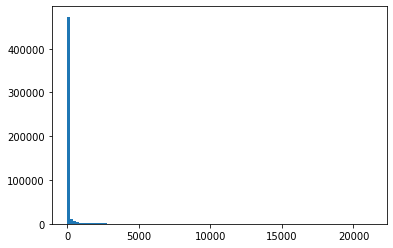

In [8]:
import matplotlib.pyplot as plt
plt.hist(up_votes, range=None,bins=100)

Build a sampler given the imbalanced training dataset.

As the following result shown, we can obtain balanced dataset after using `WeightedRandomSampler`.

In [9]:
from torch.utils.data.sampler import Sampler

data = title
target = np.array(label_list[:int(len(up_votes)*0.95)])

print ('number of labels in the imbalanced training dataset 0/1/2: {}/{}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0]), len(np.where(target == 2)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
weight[0] = weight[0]*0.95
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(data_iter[:int(len(up_votes)*0.95)], batch_size=64, shuffle=False, collate_fn=collate_batch, sampler=sampler)

#test whether we get balanced dataset
epoch = 0
for idx, (label, text, offsets) in enumerate(train_loader):
    print ("number of labels in a batch of balanced training dataset 0/1/2: {}/{}/{}".format(
        len(np.where(label.cpu().numpy() == 0)[0]),
        len(np.where(label.cpu().numpy() == 1)[0]),
        len(np.where(label.cpu().numpy() == 2)[0]),))
    epoch += 1
    if epoch == 1:
      break

number of labels in the imbalanced training dataset 0/1/2: 436433/33744/13597
number of labels in a batch of balanced training dataset 0/1/2: 15/20/29


Split the dataset and run the model
-----------------------------------

we split the dataset into train/test sets with a split ratio of 0.95 (train) and
0.05 (test).

Loss function: CrossEntropyLoss

Optimizer: stochastic gradient descent method (SGD)

Initial learning rate: 5

Batch Size: 128

Epochs: 10

Train with imbalaced dataset directly
-----------------------------------
We build model1 to train our imbalanced dataset directly.

In [10]:
num_class = 3
vocab_size = len(vocab)
emsize = 64
model1 = TextClassificationModel(vocab_size, emsize, num_class).to(device)
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 128 # batch size for training
  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_dataset = data_iter[:int(len(up_votes)*0.95)]
test_dataset = data_iter[int(len(up_votes)*0.95):]

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch, sampler=sampler)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(model1, train_dataloader)
    accu_test = evaluate(model1, test_dataloader)
    if total_accu is not None and total_accu > accu_test:
      scheduler.step()
    else:
       total_accu = accu_test
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'Test accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_test))
    print('-' * 59)

| epoch   1 |   500/ 7559 batches | accuracy    0.961
| epoch   1 |  1000/ 7559 batches | accuracy    0.947
| epoch   1 |  1500/ 7559 batches | accuracy    0.926
| epoch   1 |  2000/ 7559 batches | accuracy    0.884
| epoch   1 |  2500/ 7559 batches | accuracy    0.890
| epoch   1 |  3000/ 7559 batches | accuracy    0.905
| epoch   1 |  3500/ 7559 batches | accuracy    0.905
| epoch   1 |  4000/ 7559 batches | accuracy    0.910
| epoch   1 |  4500/ 7559 batches | accuracy    0.892
| epoch   1 |  5000/ 7559 batches | accuracy    0.885
| epoch   1 |  5500/ 7559 batches | accuracy    0.891
| epoch   1 |  6000/ 7559 batches | accuracy    0.883
| epoch   1 |  6500/ 7559 batches | accuracy    0.882
| epoch   1 |  7000/ 7559 batches | accuracy    0.890
| epoch   1 |  7500/ 7559 batches | accuracy    0.882
-----------------------------------------------------------
| end of epoch   1 | time: 23.91s | Test accuracy    0.880 
-----------------------------------------------------------
| epoch   

Train with imbalaced dataset processed with `WeightedRandomSampler`
-----------------------------------
We build model2 to train our imbalanced dataset processed with `WeightedRandomSampler`.

In [11]:
model2 = TextClassificationModel(vocab_size, emsize, num_class).to(device)
balanced_train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch, sampler=sampler) # get balanced dataset by using sampler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(model2, balanced_train_dataloader)
    accu_test = evaluate(model2, test_dataloader)
    if total_accu is not None and total_accu > accu_test:
      scheduler.step()
    else:
       total_accu = accu_test
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'Test accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_test))
    print('-' * 59)

| epoch   1 |   500/ 7559 batches | accuracy    0.392
| epoch   1 |  1000/ 7559 batches | accuracy    0.428
| epoch   1 |  1500/ 7559 batches | accuracy    0.444
| epoch   1 |  2000/ 7559 batches | accuracy    0.457
| epoch   1 |  2500/ 7559 batches | accuracy    0.466
| epoch   1 |  3000/ 7559 batches | accuracy    0.477
| epoch   1 |  3500/ 7559 batches | accuracy    0.485
| epoch   1 |  4000/ 7559 batches | accuracy    0.493
| epoch   1 |  4500/ 7559 batches | accuracy    0.501
| epoch   1 |  5000/ 7559 batches | accuracy    0.507
| epoch   1 |  5500/ 7559 batches | accuracy    0.507
| epoch   1 |  6000/ 7559 batches | accuracy    0.516
| epoch   1 |  6500/ 7559 batches | accuracy    0.525
| epoch   1 |  7000/ 7559 batches | accuracy    0.529
| epoch   1 |  7500/ 7559 batches | accuracy    0.528
-----------------------------------------------------------
| end of epoch   1 | time: 24.97s | Test accuracy    0.579 
-----------------------------------------------------------
| epoch   

Evaluate the model1 and model2 with test dataset
------------------------------------
Checking the results given the test dataset.

In order to test the performance of model1 and model2 on datasets at different popularity levels, we divide test dataset into three different classes which are `high_test_dataset`, `medium_test_dataset` and `low_test_dataset` respectively.

As the following results shown, even though the overall test accuracy of model1 is larger that the test accuracy of model2, model1 is unable to identify the minor classes such as intermidiate popularity and high popularity, whereas model2 gives a retively much better performance on these classes compared to model1. In conclusion, using `WeightedRandomSampler` is significant to our predictive model.

In [12]:
print('Checking the results of different class of test dataset.')
high_test_dataset = []
medium_test_dataset = []
low_test_dataset = []
for idx, data in enumerate(test_dataset):
  _label, text = data[0], data[1]
  if _label == 0:
    low_test_dataset.append((_label, text))
  elif _label == 1:
    medium_test_dataset.append((_label, text))
  else:
    high_test_dataset.append((_label, text))

high_test_dataloader = DataLoader(high_test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
medium_test_dataloader = DataLoader(medium_test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
low_test_dataloader = DataLoader(low_test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

high_accu_model1 = evaluate(model1.to(device), high_test_dataloader)
medium_accu_model1 = evaluate(model1.to(device), medium_test_dataloader)
low_accu_model1 = evaluate(model1.to(device), low_test_dataloader)

high_accu_model2 = evaluate(model2.to(device), high_test_dataloader)
medium_accu_model2 = evaluate(model2.to(device), medium_test_dataloader)
low_accu_model2 = evaluate(model2.to(device), low_test_dataloader)
print('Accuracy of model1 and model2 on high popularity test dataset are {:8.3f} and {:8.3f}'.format(high_accu_model1, high_accu_model2))
print('Accuracy of model1 and model2 on medium popularity test dataset are {:8.3f} and {:8.3f}'.format(medium_accu_model1, medium_accu_model2))
print('Accuracy of model1 and model2 on low test dataset are {:8.3f} and {:8.3f}'.format(low_accu_model1, low_accu_model2))

Checking the results of different class of test dataset.
Accuracy of model1 and model2 on high popularity test dataset are    0.001 and    0.484
Accuracy of model1 and model2 on medium popularity test dataset are    0.001 and    0.339
Accuracy of model1 and model2 on low test dataset are    1.000 and    0.582


Example of news in test dataset
---------------------
The up_votes of test1 is 3941, which is belongs to high popularity class

The up_votes of test2 is 536, which is belongs to intermediate popularity class

The up_votes of test3 is 0, which is belongs to low popularity class

In [14]:
ag_news_label = {0: "low popular",
                 1: "intermediate popular",
                 2: "high popular",
                 }

def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() 

test1 = "“US to quit TPP trade deal, says Trump - BBC News"
test2 = "India All Set to Launch a $2 Billion Renewable Energy Equity Fund"
test3 = 'Indian Demonetisation: Most sweeping change in currency policy in the world in decades - Larry Summers'

model1 = model1.to("cpu")
model2 = model2.to("cpu")

print('The test examples of model1:')
print("Test1 is a %s news" %ag_news_label[predict(test1, text_pipeline, model1)])
print("Test2 is a %s news" %ag_news_label[predict(test2, text_pipeline, model1)])
print("Test3 is a %s news" %ag_news_label[predict(test3, text_pipeline, model1)])
print()
print('The test examples of model2:')
print("Test1 is a %s news" %ag_news_label[predict(test1, text_pipeline, model2)])
print("Test2 is a %s news" %ag_news_label[predict(test2, text_pipeline, model2)])
print("Test3 is a %s news" %ag_news_label[predict(test3, text_pipeline, model2)])

The test examples of model1:
Test1 is a low popular news
Test2 is a low popular news
Test3 is a low popular news

The test examples of model2:
Test1 is a high popular news
Test2 is a intermediate popular news
Test3 is a high popular news


Conclusion and Business Insights
---------------------
In this project, we developed a predictive model to predict the potential popularity given a news' title. It is meaningful to Eluvio company which is the first blockchain-backed 4K streaming and ticketing platform for direct from artist to fan distribution. We can use this model to predict the popularity of each titile and push the most likely popular one to the customers.

Future Works
---------------------


1.   Convert this deterministic neural network to Bayesian framework, which is able to give more robust predictions with confidence interval and avoid overfitting problem especially when dataset is in small size or imbalanced.
2.   Even though `WeightedRandomSampler` is working when dataset is imbalanced, however it is easy to introduce overfitting or underfitting problems. We can collect dataset at each class equally to build a balanced dataset at beginning.
3.   For natural language process, transformer is the most popular model nowadays, I also build a model based on transformer in Eluvio_challenge_2.ipynb. But I did not finish training it due to the computing resource, Eluvio_challenge_2.ipynb is just an extension of this project.
